In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation 
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [2]:
if os.path.isfile('final_features.csv'):
    data = pd.read_csv('final_features.csv',nrows=50000,encoding='latin-1')

In [3]:
data.head(3)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075


<h2> 4.3 Random train test split( 70:30) </h2>

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,data['is_duplicate'],stratify=data['is_duplicate'], random_state=32)

In [5]:
X_train.shape

(37500, 797)

In [6]:
X_train.head(2)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
23561,23561,23561,0,0.333322,0.333322,0.749981,0.428565,0.57142,0.399996,0.0,...,10.081100,7.293092,-2.301826,-2.388097,8.174289,10.060930,-9.763494,11.499752,3.128849,6.696956
3536,3536,3536,0,0.000000,0.000000,0.333322,0.166664,0.11111,0.083333,0.0,...,-2.909032,9.692300,5.944170,-0.984370,18.724181,5.324348,-10.590964,-1.622753,11.326696,5.985359


In [7]:
# extraction  features from train  data frame 
X_train = X_train.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=False)

# extraction  features from test data frame 
X_test = X_test.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=False)


In [8]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (37500, 794)
Number of data points in test data : (12500, 794)


In [9]:
y_train.shape

(37500,)

In [10]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6270133333333333 Class 1:  0.3729866666666667
---------- Distribution of output variable in train data ----------
Class 0:  0.37296 Class 1:  0.37296


In [11]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8925361478155392


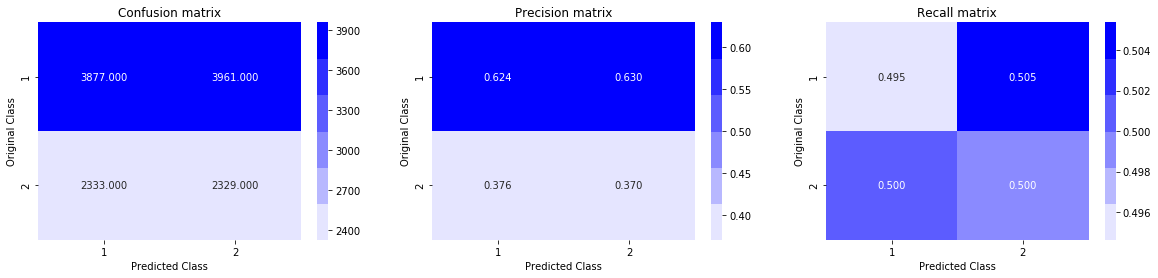

In [28]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6605122740522953
For values of alpha =  0.0001 The log loss is: 0.4888800349561221
For values of alpha =  0.001 The log loss is: 0.4736458076347022
For values of alpha =  0.01 The log loss is: 0.47214640839536237
For values of alpha =  0.1 The log loss is: 0.46414134136740687
For values of alpha =  1 The log loss is: 0.47881206129679443
For values of alpha =  10 The log loss is: 0.5134967479234314


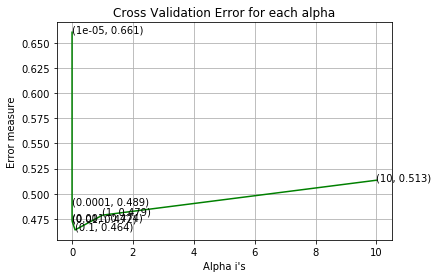

For values of best alpha =  0.1 The train log loss is: 0.4529972945367734
For values of best alpha =  0.1 The test log loss is: 0.46414134136740687
Total number of data points : 12500


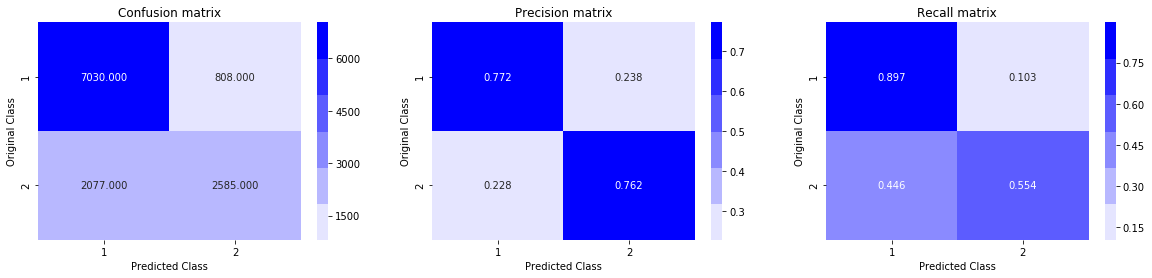

In [29]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6605122740522953
For values of alpha =  0.0001 The log loss is: 0.6605122740522953
For values of alpha =  0.001 The log loss is: 0.6605122740522953
For values of alpha =  0.01 The log loss is: 0.6605122740522953
For values of alpha =  0.1 The log loss is: 0.6174979074845539
For values of alpha =  1 The log loss is: 0.6497430929377376
For values of alpha =  10 The log loss is: 0.6605122740522953


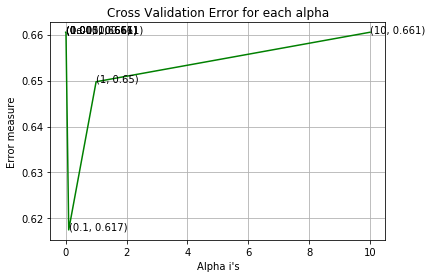

For values of best alpha =  0.1 The train log loss is: 0.615908117843384
For values of best alpha =  0.1 The test log loss is: 0.6174979074845539
Total number of data points : 12500


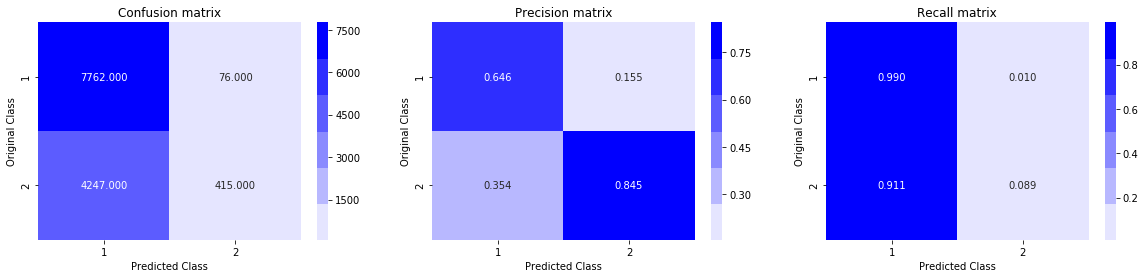

In [12]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [13]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684857	valid-logloss:0.684907
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.614836	valid-logloss:0.615142
[20]	train-logloss:0.564041	valid-logloss:0.564804
[30]	train-logloss:0.525761	valid-logloss:0.526967
[40]	train-logloss:0.495933	valid-logloss:0.497552
[50]	train-logloss:0.472758	valid-logloss:0.474766
[60]	train-logloss:0.454693	valid-logloss:0.456985
[70]	train-logloss:0.439819	valid-logloss:0.442398
[80]	train-logloss:0.427801	valid-logloss:0.430645
[90]	train-logloss:0.417949	valid-logloss:0.421193
[100]	train-logloss:0.409793	valid-logloss:0.413345
[110]	train-logloss:0.402909	valid-logloss:0.406724
[120]	train-logloss:0.397028	valid-logloss:0.401113
[130]	train-logloss:0.392247	valid-logloss:0.396673
[140]	train-logloss:0.387823	valid-logloss:0.392557
[150]	train-logloss:0.384121	valid-logloss:0.389151
[160]	train-logloss:0.380777

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 1.  Let us Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
## 2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


### 5.1 Reading data from file

In [77]:

if os.path.isfile('nlp_features_train.csv'):
    df1 = pd.read_csv("nlp_features_train.csv",nrows=50000,encoding='latin-1')

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [78]:
df1.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [79]:
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
dfnlp = df1.merge(df2, on='id',how='left')

In [80]:
dfnlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [81]:
nan_rows = dfnlp[dfnlp.isnull().any(1)]
print (nan_rows)

          id   qid1   qid2                                          question1  \
3306    3306   6553   6554                                                NaN   
13016  13016  25026  25027                                                NaN   
20072  20072  37898  37899                            how could i solve this    
20794  20794  39204  39205                                                NaN   
47056  47056  84067  84068  is there anywhere in the world offering pain m...   

                                               question2  is_duplicate  \
3306   why is cornell own endowment the lowest in the...             0   
13016                 why should one not work at google              0   
20072                                                NaN             0   
20794  what is the gmail tech support help phone number              0   
47056                                                NaN             0   

       cwc_min  cwc_max  csc_min  csc_max  ...  freq_qid2  q1len  q2

In [82]:
# Filling the null values with ' '
dfnlp = dfnlp.fillna('')
nan_rows = dfnlp[dfnlp.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 32 columns]


### 5.2 Splitting data into Train and cross validation(or test): Stratified Sampling

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfnlp,dfnlp['is_duplicate'],stratify=dfnlp['is_duplicate'], random_state=32)


In [84]:
X_train= X_train.drop(('is_duplicate'),axis=1)
X_train.shape

(37500, 31)

In [85]:
y_train.shape

(37500,)

In [86]:
y_test.shape

(12500,)

In [87]:
X_test= X_test.drop(('is_duplicate'),axis=1)
X_test.shape

(12500, 31)

In [88]:
X_train.head()

,id,qid1,qid2,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
23561,23561,44124,44125,how do i learn geography for nda,how do i learn to accept myself and my appeara...,0.333322,0.333322,0.749981,0.428565,0.571420,...,1,33,50,7,10,4.0,17.0,0.235294,2,0
3536,3536,7006,7007,what happens when 0 gb disk space is reached,is there a pokemon fan game or romhack set dur...,0.000000,0.000000,0.333322,0.166664,0.111110,...,1,46,58,10,12,1.0,22.0,0.045455,2,0
33192,33192,61018,19621,why do people ask so many googleable questions...,why do some people ask questions on quora that...,0.666656,0.399996,0.749981,0.374995,0.699993,...,23,56,97,10,18,6.0,28.0,0.214286,55,9
35725,35725,65244,65245,what is china doing to help nepal,how can we help nepal,0.999950,0.666644,0.000000,0.000000,0.399992,...,1,34,22,7,5,2.0,12.0,0.166667,2,0
6320,6320,12389,12390,what are the best education portals in india,which are the best sites for free education in...,0.749981,0.599988,0.749981,0.599988,0.749991,...,1,45,53,8,10,6.0,18.0,0.333333,3,1


###  5.3 TFIDF vectorizer on Questions Text Data

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)

# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

vectorizer.fit(questions)




TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

#### Train Data

In [90]:
tfidf_train_ques1= vectorizer.transform(X_train['question1'])
print("Shape of matrix after one hot encodig ",tfidf_train_ques1.shape)

print("the number of unique words ", tfidf_train_ques1.get_shape()[1])



Shape of matrix after one hot encodig  (37500, 13365)
the number of unique words  13365


In [91]:

tfidf_train_ques2= vectorizer.transform(X_train['question2'])
print("Shape of matrix after one hot encodig ",tfidf_train_ques2.shape)
print("the number of unique words ", tfidf_train_ques2.get_shape()[1])


Shape of matrix after one hot encodig  (37500, 13365)
the number of unique words  13365


In [92]:
# extraction  features from train  data frame 
X_train_feature_df = X_train.drop(['id','qid1','qid2','question1','question2'], axis=1, inplace=False)

In [93]:
X_train_feature_df.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
23561,0.333322,0.333322,0.749981,0.428565,0.57142,0.399996,0.0,1.0,3.0,8.5,...,1,33,50,7,10,4.0,17.0,0.235294,2,0
3536,0.000000,0.000000,0.333322,0.166664,0.11111,0.083333,0.0,0.0,3.0,10.5,...,1,46,58,10,12,1.0,22.0,0.045455,2,0


In [94]:
import scipy
# X_train.head()
print("train Shape Before -> ",X_train_feature_df.shape," Type",type(X_train_feature_df))

#so we need to convert our feature data into sparse matrix so that we will combine our feature and and tfidf vec 
train_feat_sparse = scipy.sparse.csr_matrix(X_train_feature_df)

print("train Shape After-> ",train_feat_sparse.shape," Type",type(train_feat_sparse))

train Shape Before ->  (37500, 26)  Type <class 'pandas.core.frame.DataFrame'>
train Shape After->  (37500, 26)  Type <class 'scipy.sparse.csr.csr_matrix'>


####  TEST Data

In [95]:
tfidf_test_ques1= vectorizer.transform(X_test['question1'])
print("Shape of matrix after one hot encodig ",tfidf_test_ques1.shape)
print("the number of unique words ", tfidf_test_ques1.get_shape()[1])




Shape of matrix after one hot encodig  (12500, 13365)
the number of unique words  13365


In [96]:
tfidf_test_ques2= vectorizer.transform(X_test['question2'])
print("Shape of matrix after one hot encodig ",tfidf_test_ques2.shape)
print("the number of unique words ", tfidf_test_ques2.get_shape()[1])




Shape of matrix after one hot encodig  (12500, 13365)
the number of unique words  13365


In [97]:
tfidf_train_ques2

<37500x13365 sparse matrix of type '<class 'numpy.float64'>'
	with 539267 stored elements in Compressed Sparse Row format>

In [99]:
# extraction  features from test  data frame 
X_test_feature_df = X_test.drop(['id','qid1','qid2','question1','question2'], axis=1, inplace=False)


print("test Shape Before -> ",X_test_feature_df.shape," Type",type(X_test_feature_df))

#so we need to convert our feature data into sparse matrix so that we will combine our feature and and tfidf vec 
test_feat_sparse = scipy.sparse.csr_matrix(X_test_feature_df)

print("test Shape After-> ",test_feat_sparse.shape," Type",type(test_feat_sparse))

test Shape Before ->  (12500, 26)  Type <class 'pandas.core.frame.DataFrame'>
test Shape After->  (12500, 26)  Type <class 'scipy.sparse.csr.csr_matrix'>


In [100]:
# combining our tfidf and features into one 

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack


tfidf_train = hstack((train_feat_sparse,tfidf_train_ques1,tfidf_train_ques2))

# test features(feat + tfidfvec)
tfidf_test = hstack((test_feat_sparse,tfidf_test_ques1,tfidf_test_ques2))

#final train and test data shape 
print("train data shape",tfidf_train.shape)

print("Test data shape ",tfidf_test.shape)

train data shape (37500, 26756)
Test data shape  (12500, 26756)


In [101]:
print("Final Shape of the Data matrix")
print(tfidf_train.shape, y_train.shape)

print(tfidf_test.shape, y_test.shape)

Final Shape of the Data matrix
(37500, 26756) (37500,)
(12500, 26756) (12500,)


In [102]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6270133333333333 Class 1:  0.3729866666666667
---------- Distribution of output variable in train data ----------
Class 0:  0.37296 Class 1:  0.37296


### 5.4  Function For Confusion Matrix

In [103]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## 5.5 Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8901674381797021


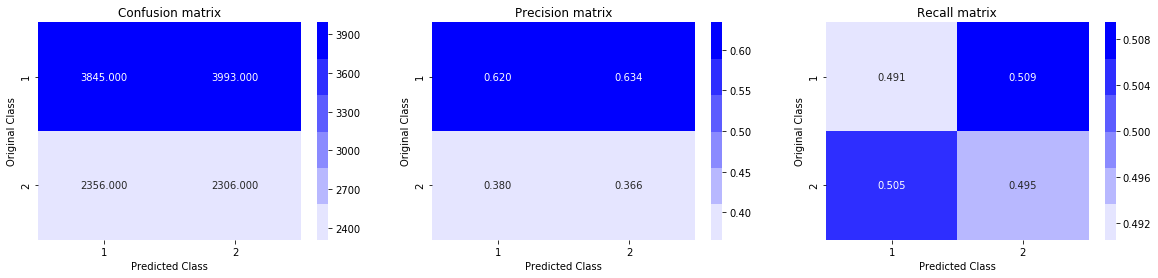

In [104]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## 5.6 Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.44216431191931754
For values of alpha =  0.0001 The log loss is: 0.44195102131758845
For values of alpha =  0.001 The log loss is: 0.4474409270396936
For values of alpha =  0.01 The log loss is: 0.4545805087125833
For values of alpha =  0.1 The log loss is: 0.46435830292587255
For values of alpha =  1 The log loss is: 0.4908037092898735
For values of alpha =  10 The log loss is: 0.5451775161339065


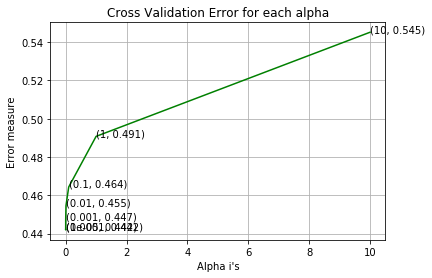

For values of best alpha =  0.0001 The train log loss is: 0.4321466655412
For values of best alpha =  0.0001 The test log loss is: 0.44195102131758845
Total number of data points : 12500


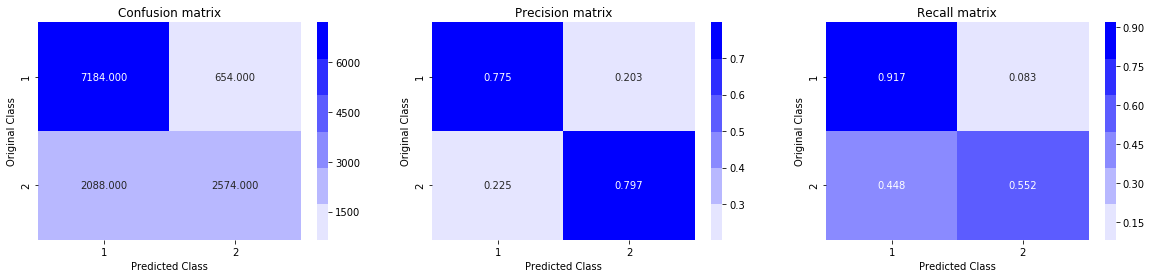

In [106]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=�hinge�, penalty=�l2�, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=�optimal�, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, �])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, y_train)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 5.7 Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.43971930193051834
For values of alpha =  0.0001 The log loss is: 0.4609187140027068
For values of alpha =  0.001 The log loss is: 0.4735602155265986
For values of alpha =  0.01 The log loss is: 0.5219821811005141
For values of alpha =  0.1 The log loss is: 0.48432305969677136
For values of alpha =  1 The log loss is: 0.5749588676366658
For values of alpha =  10 The log loss is: 0.6335853743705856


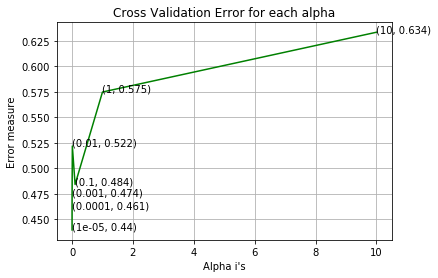

For values of best alpha =  1e-05 The train log loss is: 0.4228898295834066
For values of best alpha =  1e-05 The test log loss is: 0.43971930193051834
Total number of data points : 12500


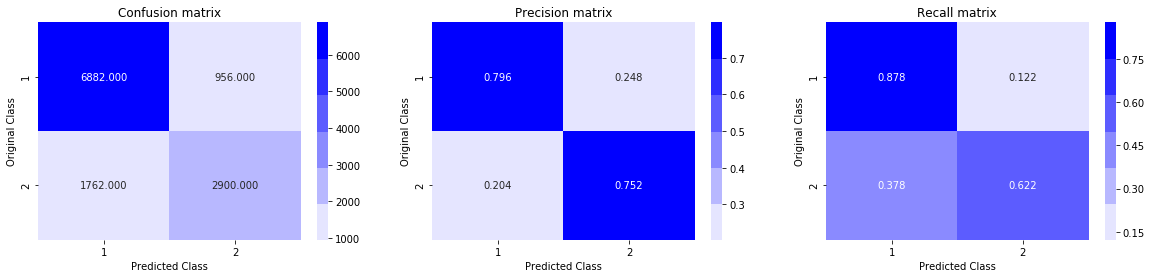

In [107]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=�hinge�, penalty=�l2�, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=�optimal�, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, �])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, y_train)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 5.8 XGBoost

#### A.  Hyperparameter Tuning

In [112]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as sc




params = {
        
        "learning_rate":sc.uniform(0.05,0.3),
        'max_depth': sc.randint(3,15),
        'n_estimators' : sc.randint(10,200),
        "min_child_weight" : [ 1, 3, 5, 7 ],
        'gamma': sc.uniform(0.0,0.5)
        }
x_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)

xgb_random_search = RandomizedSearchCV(x_model, param_distributions = params,n_iter=30,
                         scoring = 'neg_log_loss', n_jobs = -1,cv=3)

xgb_random_search.fit(tfidf_train, y_train)


print("Score : ",xgb_random_search.best_score_)
print("Best Params",xgb_random_search.best_params_)

Score :  -0.3362009610550548
Best Params {'max_depth': 10, 'gamma': 0.3568940155853951, 'learning_rate': 0.10427552222917388, 'n_estimators': 187, 'min_child_weight': 7}


#### B. With Best Params

The train log loss is:  0.25063749795935275
The test log loss is :  0.3456727417814455


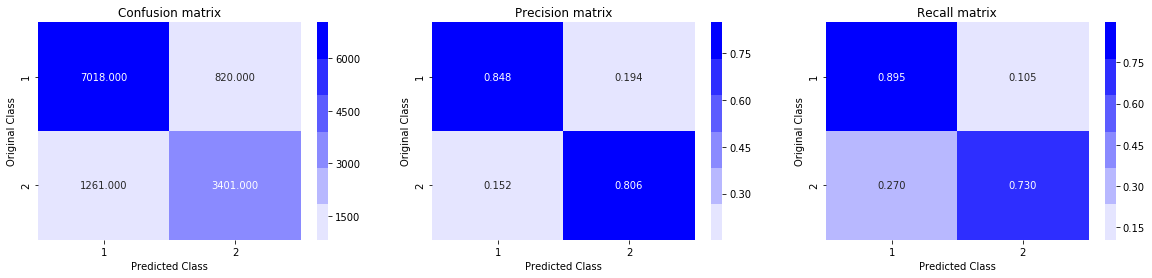

In [114]:
bst = xgb.XGBClassifier(max_depth=10,learning_rate=0.1042,objective='binary:logistic',gamma=0.35,n_estimators=187,min_child_weight=7,n_jobs=-1)
bst.fit(tfidf_train, y_train)   


clf_calib = CalibratedClassifierCV(bst, method="sigmoid")
clf_calib.fit(tfidf_train, y_train)

predict_y = clf_calib.predict_proba(tfidf_train)

print("The train log loss is: ",log_loss(y_train, predict_y,labels=bst.classes_, eps=1e-15))

predict_y = clf_calib.predict_proba(tfidf_test)
print("The test log loss is : ",log_loss(y_test, predict_y,labels=bst.classes_, eps=1e-15))


predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Obseravtions

In [15]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ['Serial No.', 'Model Name', 'Tokenizer','Hyperparameter Tunning', 'Test Log Loss']
ptable.add_row(["1","Random","TFIDF Weighted W2V","-","0.89"])
ptable.add_row(["2","Logistic Regression","TFIDF Weighted W2V","Done","0.46"])
ptable.add_row(["3","Linear SVM","TFIDF Weighted W2V","Done","0.61"])
ptable.add_row(["4","XGBoost","TFIDF Weighted W2V","-","0.35"])
ptable.add_row(["\n","\n","\n","\n","\n"])
ptable.add_row(["1","Random","TFIDF","-","0.88"])
ptable.add_row(["2","Logistic Regression","TFIDF","Done","0.44"])
ptable.add_row(["3","Linear SVM","TFIDF","Done","0.539"])
ptable.add_row(["4","XGBoost","TFIDF","Done","0.34"])
print(ptable)

+------------+---------------------+--------------------+------------------------+---------------+
| Serial No. |      Model Name     |     Tokenizer      | Hyperparameter Tunning | Test Log Loss |
+------------+---------------------+--------------------+------------------------+---------------+
|     1      |        Random       | TFIDF Weighted W2V |           -            |      0.89     |
|     2      | Logistic Regression | TFIDF Weighted W2V |          Done          |      0.46     |
|     3      |      Linear SVM     | TFIDF Weighted W2V |          Done          |      0.61     |
|     4      |       XGBoost       | TFIDF Weighted W2V |           -            |      0.35     |
|            |                     |                    |                        |               |
|            |                     |                    |                        |               |
|     1      |        Random       |       TFIDF        |           -            |      0.88     |
|     2   

# Conclusions

According to our ploblem statment we have to Identify which questions asked on Quora are duplicates of questions that have already been asked. so thatThis could be useful to instantly provide answers to questions that have already been answered.here We are tasked with predicting whether a pair of questions are duplicates or not.

1. As we know we have data set which contains Number of rows 404,290, which contains 5 columns : qid1, qid2, question1, question2, is_duplicate from which 'is_duplicate' is a class lable which specify that the question 1 and question 2 is similar or not and this is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.


2.  Firstly we preprocessed our data,did feature engineering to create new features which might help us and  created our dataframes, then we merged dataframes and got out final matrix.Now after doing simple EDA on dataset we will try some Basic Feature Extraction (before cleaning) the datset like Frequency of qid1's ,word_Common and etc. and using this featured datset we will do some EDA on it so that we will able to rectify which features are most useful features our of all features i.e(wich feature is helpful for classification)

3. After doing basic Basic feature extractions we will try some Advanced Feature Extraction using NLP and Fuzzy Features but before doing this we will do Preprocessing of Text and then we will do Advanced Feature Extraction and try to visualise our Advanced Feature using EDA, PCA and word clouds.

4. Then we Splitted out data randomly  . We could also have done time based splitting, since the model could predict for future unseen data too.  But, there was no timestamp column provided, so the only option was to split it randomly.

5. Now as we know we have columns of two questions i.e question 1 and question 2 and we will vectorize that both col using tfidf weighted word-vectors so that we will able to apply models on it and after doing all these we will merge all the features i.e besic features + advance features + question1 tfidf w2v + and question 2 tfidf w2v. and Now after doing all of there we will apply models on it.

6. Here as we know here we are using two main performance matrix in this case study i.e log-loss and confusion matrix and using there we will get our performsnce of the models

7. Lets start: here we are there model i.e Logistic Regression linear svm and XgBoost and a random model which Finding worst-case log-loss and then we try to comparse all

8. In next step we will try our models with other vectorizer i.e tfidf instead of tfidf weighted w2v and try to do some hyperparameter tuning in order to improve the model performance.


9. Now, we have applied simple Random/Dumb Model. It gave a log loss of 0.89. This is the worst case log-loss. This will act as a base and any model we design should have a log-loss lesser than this dumb model.

10. After that we have applied Logistic Regression with hyperparameter tuning. It gave a log-loss of 0.44, which is  lower than Random Model. We can also see that there is no Overfitting problem , since, Train log-loss and Test log-loss and very close.

11. After that we have applied Linear SVM with hyperparameter tuning. It gave the log-loss of 0.539,which is lower than Random Model. We can also see that there is no Overfitting problem , since, Train log-loss and Test log-loss and very close.

12. After that we have applied Xgboost with hyperparameter tuning. It gave the log-loss of 0.34,which is lower than Random Model. We can also see that there is no Overfitting problem , since, Train log-loss and Test log-loss and very close.

#### Looks like among all the models that we tried Xgboost seems to perform well and hence can be used to Identify which questions asked on Quora are duplicates of questions that have already been asked.